In [31]:
import numpy as np
import watercolor_light
import matplotlib.pyplot as plt
import pygio

In [32]:
filters = watercolor_light.Filters()
sps_library = watercolor_light.SPSLibraryData()
h = 0.6766
z_solar = 0.019

In [33]:
basepath = "/raid/ci_cels/subgrid/20240610_1304_REVISION_8bc4545f"
gal_path = f"{basepath}/analysis/m000p-624.galaxyproperties"
gal_data = pygio.read_genericio(gal_path)

Read 95 variables from /raid/ci_cels/subgrid/20240610_1304_REVISION_8bc4545f/analysis/m000p-624.galaxyproperties (279599 bytes) in 0.00616646s: 43.2414 MB/s [excluding header read]


In [34]:
galpart_path = f"{basepath}/analysis/m000p-624.galaxyparticles"
galpart_data = pygio.read_genericio(galpart_path)

galpart_path_sg = f"{basepath}/analysis/m000p-624.galaxyparticles.subgrid"
galpart_data_sg = pygio.read_genericio(galpart_path_sg)


def get_star_mask(mask):
    mask_bar = np.bitwise_and(mask, 4) > 0
    mask_dead = np.bitwise_and(mask, 128) > 0
    mask_star = np.bitwise_and(mask, 16) > 0
    mask_star &= ~mask_dead
    mask_star &= mask_bar
    return mask_star


mask_star = get_star_mask(galpart_data["mask"])
galstarpart_data = {k: d[mask_star] for k, d in galpart_data.items()}
s = np.argsort(galstarpart_data["id"])
galstarpart_data = {k: d[s] for k, d in galstarpart_data.items()}

mask_star = get_star_mask(galpart_data_sg["mask"])
galstarpart_data_sg = {k: d[mask_star] for k, d in galpart_data_sg.items()}
s = np.argsort(galstarpart_data_sg["id"])
galstarpart_data_sg = {k: d[s] for k, d in galstarpart_data_sg.items()}

assert np.all(galstarpart_data["id"] == galstarpart_data_sg["id"])
assert np.all(galstarpart_data["mask"] == galstarpart_data_sg["mask"])
for k, d in galstarpart_data_sg.items():
    galstarpart_data[k] = d

Read 16 variables from /raid/ci_cels/subgrid/20240610_1304_REVISION_8bc4545f/analysis/m000p-624.galaxyparticles (11314757 bytes) in 0.383935s: 28.1053 MB/s [excluding header read]
Read 6 variables from /raid/ci_cels/subgrid/20240610_1304_REVISION_8bc4545f/analysis/m000p-624.galaxyparticles.subgrid (758324 bytes) in 0.190814s: 3.79006 MB/s [excluding header read]


## Single Galaxy

In [35]:
target_idx = np.argmax(gal_data["gal_mass_star"])
target_tag = gal_data["gal_tag"][target_idx]

mask = galstarpart_data["gal_tag"] == target_tag

metallicities = galstarpart_data["zmet"][mask]
metallicities /= z_solar
ages = galstarpart_data["tage"][mask]
# convert from 1/H0 units to Gyr
# H0: 100h km/s/Mpc.
# 1 Gyr = 1e9 years = 1e9 * 365.25 * 24 * 3600 seconds
# 1 Mpc = 3.08567758128e19 km
H0inv_in_Gyr = 1 / (100 * h * (1e9 * 365.25 * 24 * 3600 / 3.08567758128e19))
ages *= 1 * H0inv_in_Gyr
masses = galstarpart_data["mass"][mask] / h  # in Msun

In [36]:
galstarpart_data["tage"][mask].max()

0.89328223

In [37]:
H0inv_in_Gyr

14.451555152435871

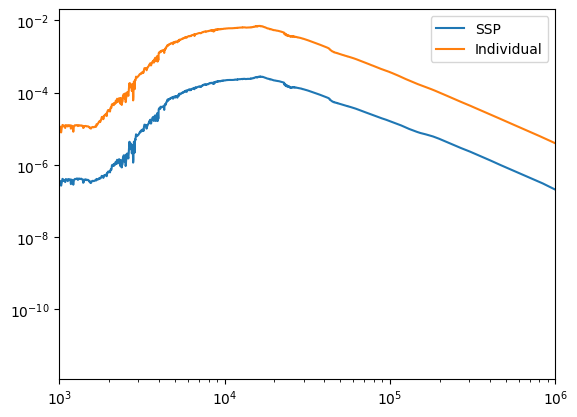

In [38]:
total_flux, luminosty = watercolor_light.calc_galaxy_flux(
    ages, metallicities, masses, sps_library
)

total_flux2, luminosty2 = watercolor_light.calc_galaxy_flux(
    ages, metallicities, masses, sps_library, method="individual"
)

fig, ax = plt.subplots()
ax.plot(sps_library.wave, total_flux, label="SSP")
ax.plot(sps_library.wave, total_flux2, label="Individual")
ax.set(xscale="log", yscale="log")
ax.set(xlim=(1e3, 1e6))
ax.legend()

### Convolve with bands

In [39]:
filter = filters["LSST"]
photo = watercolor_light.photometry_from_spectra(
    1e-4 * sps_library.wave,
    1e-3 * total_flux,
    filter.bandpass_wavelengths,
    filter.bandpass_values,
)

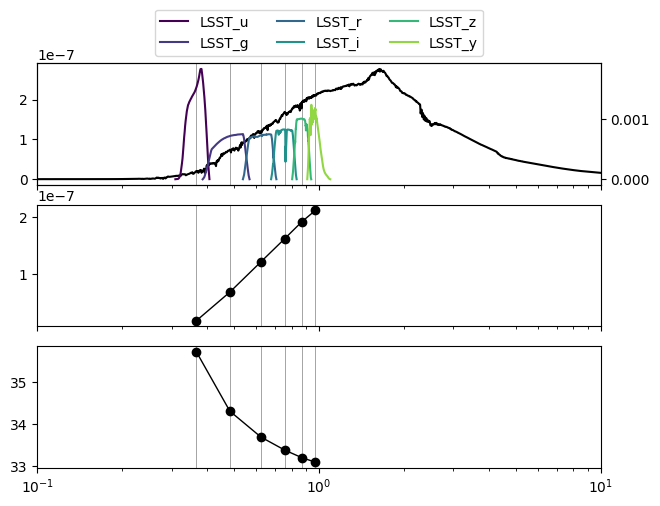

In [40]:
fig, axes = plt.subplots(3, 1)
ax = axes[0]
ax.plot(1e-4 * sps_library.wave, 1e-3 * total_flux, label="SSP", color="black")
tax = ax.twinx()
for i, (w, f) in enumerate(zip(filter.bandpass_wavelengths, filter.bandpass_values)):
    color = plt.get_cmap("viridis")(i / len(filter.bandpass_wavelengths))
    tax.plot(w, f, color=color, label=filter.bandpass_names[i])


axes[1].plot(
    filter.central_wavelengths,
    photo.band_fluxes,
    color="black",
    marker="o",
    linewidth=1,
)
axes[2].plot(
    filter.central_wavelengths,
    photo.appmag_ext,
    color="black",
    marker="o",
    linewidth=1,
)


for ax in axes:
    ax.set(xscale="log", xlim=(1e-1, 1e1))
for ax in axes[:-1]:
    ax.set_xticklabels([])
for ax in axes:
    ax.vlines(
        filter.central_wavelengths,
        0,
        1,
        color="black",
        alpha=0.5,
        linewidth=0.5,
        transform=ax.get_xaxis_transform(),
    )
tax.legend(loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.5))
fig.tight_layout(pad=0)

In [41]:
print("G-R:", photo.appmag_ext[1] - photo.appmag_ext[2])

G-R: 0.6210251


## Full Catalog Colors

In [42]:
mask = gal_data["gal_mass_star"] > 1e10
gal_tags = gal_data["gal_tag"][mask]
gal_mags = np.empty((len(gal_tags), len(filter.bandpass_names)), dtype=np.float32)

for i, target_tag in enumerate(gal_tags):
    mask = galstarpart_data["gal_tag"] == target_tag
    metallicities = galstarpart_data["zmet"][mask] / z_solar
    ages = galstarpart_data["tage"][mask]
    ages *= 1 * H0inv_in_Gyr
    masses = galstarpart_data["mass"][mask] / h

    total_flux, luminosty = watercolor_light.calc_galaxy_flux(
        ages, metallicities, masses, sps_library
    )
    photo = watercolor_light.photometry_from_spectra(
        1e-4 * sps_library.wave,
        1e-3 * total_flux,
        filter.bandpass_wavelengths,
        filter.bandpass_values,
    )
    gal_mags[i] = photo.appmag_ext

In [43]:
print(filter.bandpass_names)

['LSST_u', 'LSST_g', 'LSST_r', 'LSST_i', 'LSST_z', 'LSST_y']


[Text(0.5, 0, 'g - r'), Text(0, 0.5, 'N')]

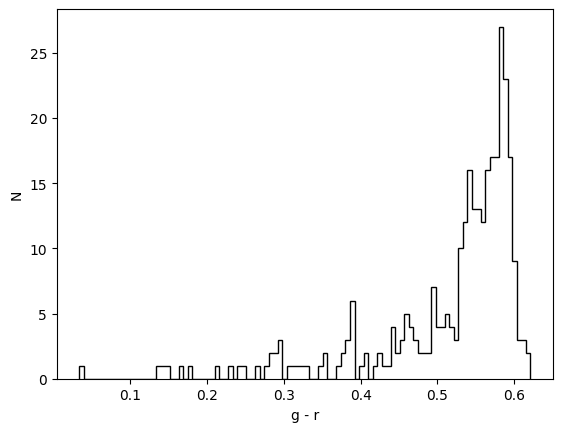

In [44]:
gminusr = gal_mags[:, 1] - gal_mags[:, 2]
rminusi = gal_mags[:, 2] - gal_mags[:, 3]

fig, ax = plt.subplots()
ax.hist(gminusr, bins=100, histtype="step", color="black")
ax.set(xlabel="g - r", ylabel="N")

[Text(0.5, 0, 'u'), Text(0, 0.5, 'g - r')]

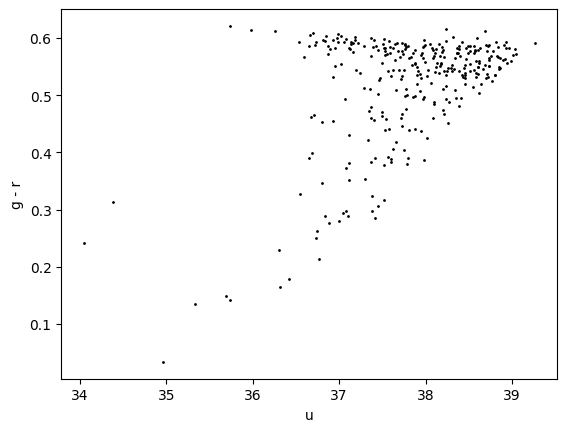

In [45]:
fig, ax = plt.subplots()
ax.scatter(
    gal_mags[:, 0],
    gminusr,
    s=1,
    color="black",
)
ax.set(xlabel="u", ylabel="g - r")

[Text(0.5, 0, 'u'), Text(0, 0.5, 'r - i')]

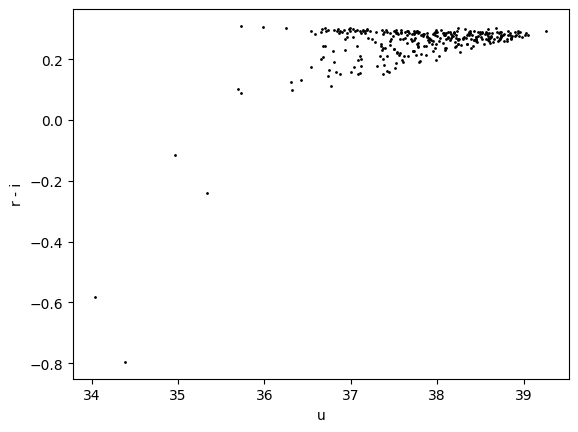

In [46]:
fig, ax = plt.subplots()
ax.scatter(
    gal_mags[:, 0],
    rminusi,
    s=1,
    color="black",
)
ax.set(xlabel="u", ylabel="r - i")

## Debug

In [47]:
a = sps_library.age
print(np.diff(a))
print(np.diff(np.log10(a)))

[3.85856232e-05 4.32937813e-05 4.85764216e-05 5.45036415e-05
 6.11540916e-05 6.86160193e-05 7.69884399e-05 8.63824503e-05
 9.69227034e-05 1.08749062e-04 1.22018454e-04 1.36906957e-04
 1.53612133e-04 1.72355648e-04 1.93386218e-04 2.16982905e-04
 2.43458824e-04 2.73165293e-04 3.06496500e-04 3.43894729e-04
 3.85856232e-04 4.32937813e-04 4.85764216e-04 5.45036415e-04
 6.11540916e-04 6.86160193e-04 7.69884399e-04 8.63824503e-04
 9.69227034e-04 1.08749062e-03 1.22018454e-03 1.36906957e-03
 1.53612133e-03 1.72355648e-03 1.93386218e-03 2.16982905e-03
 2.43458824e-03 2.73165293e-03 3.06496500e-03 3.43894729e-03
 3.85856232e-03 4.32937813e-03 4.85764216e-03 5.45036415e-03
 6.11540916e-03 6.86160193e-03 7.69884399e-03 8.63824503e-03
 9.69227034e-03 1.08749062e-02 1.22018454e-02 1.36906957e-02
 1.53612133e-02 1.72355648e-02 1.93386218e-02 2.16982905e-02
 2.43458824e-02 2.73165293e-02 3.06496500e-02 3.43894729e-02
 3.85856232e-02 4.32937813e-02 4.85764216e-02 5.45036415e-02
 6.11540916e-02 6.861601

In [48]:
m = sps_library.metallicity
print(np.diff(m))
print(np.diff(np.log10(m)))

[0.00526316 0.00526316 0.00526316 0.00526316 0.01052632 0.01052632
 0.01052632 0.02105263 0.02105263 0.02631579 0.03157895 0.04210526
 0.05263158 0.06315789 0.08421053 0.1        0.12631579 0.15789474
 0.21052632 0.26315789 0.31578947]
[0.17609126 0.12493874 0.09691001 0.07918125 0.12493874 0.09691001
 0.07918125 0.12493874 0.09691001 0.09691001 0.09342169 0.09970291
 0.09913147 0.09513375 0.10116089 0.09578051 0.09691001 0.09691001
 0.10266234 0.10145764 0.09691001]


In [49]:
m

array([0.01052632, 0.01578947, 0.02105263, 0.02631579, 0.03157895,
       0.04210526, 0.05263158, 0.06315789, 0.08421053, 0.10526316,
       0.13157895, 0.16315789, 0.20526316, 0.25789474, 0.32105263,
       0.40526316, 0.50526316, 0.63157895, 0.78947368, 1.        ,
       1.26315789, 1.57894737])